# Project 3: Multi-label Classification of Image Data (GROUP 65)
 Kynan Nedellec (260866794), Viet Tran (260924954), Oliver Stappas (260930067)


In [ ]:
import pickle
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torchvision.models as models
import cv2
import matplotlib.ticker as mtick

#**Helper functions and classes**

In [ ]:
# Preprocessing data
class MyCustomDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels=None, transforms=None):
        self.data = data.reshape(data.shape[0], data.shape[1], data.shape[2], 1)
        self.labels = labels
        self.transforms = transforms

    def __getitem__(self, index):
        
        data = self.data[index]

        if transforms is not None:
            data = self.transforms(self.data[index])

        if self.labels is not None:
            return (data, self.labels[index])

        return data

    def __len__(self):
        return self.data.shape[0]

# **Importing data**

In [ ]:
# Importing and Reading files
with open("images_l.pkl", "rb") as f:
    data = pickle.load(f)
with open("labels_l.pkl", "rb") as f:
    labels = pickle.load(f)
with open("images_test.pkl", "rb") as f:
    test = pickle.load(f)

for i in range(9):
  # define subplot
  plt.subplot(330 + 1 + i)
  # plot raw pixel data
  plt.imshow(data[i])
# show the figure
plt.show()


In [ ]:
#Converting labels from binary
def combine(labels):
    new_labels = []
    for label in labels:
        digits = label[:10]
        characters = label[10:]
        new_labels.append((np.nonzero(digits)[0] * 26 + np.nonzero(characters)[0])[0])
    return new_labels

new_labels = combine(labels)


####Preprocess and split the data

In [ ]:
# Splitting dataset
train_size = int(0.8 * (len(data)))

x_validation = data[train_size:]
y_validation = new_labels[train_size:]
x_train = data[:train_size]
y_train = new_labels[:train_size]

train_dataset = MyCustomDataset(
    x_train,
    y_train,
    transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(np.mean(x_train), np.std(x_train)),
            torchvision.transforms.RandomAffine(
                5, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=0.1
            ),
        ]
    ),
)

validation_dataset = MyCustomDataset(
    x_validation,
    y_validation,
    transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(np.mean(x_validation), np.std(x_validation)),
        ]
    ),
)

dataset_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=128, shuffle=True
)
validation_loader = torch.utils.data.DataLoader(
    dataset=validation_dataset, batch_size=128, shuffle=False
)

In [ ]:
# test data
test_dataset = MyCustomDataset(
    test,
    transforms=transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize(np.mean(test), np.std(test))]
    ),
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=128, shuffle=False
)


# **Training Methods**

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# train the network
def train_model(net, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        print("Training epoch %d" % (epoch + 1))

        running_loss = 0.0
        for i, data in enumerate(dataset_loader, 0):
            # get the inputs; data is a list of [inputs, labels]

            inputs, labels = data[0].to(device), data[1].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs.float())

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # print statistics
            running_loss += loss.item()
            if i % 25 == 24:  # print every 100 mini-batches
                print("\t[Minibatches %d] loss: %.4f" % (i + 1, running_loss / 25))
                running_loss = 0.0


# **Final Model Definition**

## Mnasnet

In [ ]:
# mnasnet0_5
mnasnet0_5 = models.mnasnet0_5(num_classes=260, pretrained=False)
mnasnet0_5.layers[0] = nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

train_model(
    mnasnet0_5.to(device),
    nn.CrossEntropyLoss(),
    optim.Adam(mnasnet0_5.parameters(), lr=0.001, weight_decay=1e-5),
    5,
)


## Densenet

In [ ]:
# densenet201
densenet201 = models.densenet201(num_classes=260, pretrained=False)
densenet201.features[0] = nn.Conv2d(
    1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
)

train_model(
    densenet201.to(device),
    nn.CrossEntropyLoss(),
    optim.Adam(densenet201.parameters(), lr=0.001, weight_decay=1e-5),
    35,
)

## Regnet

In [ ]:
# regnet_y_400mf
regnet_y_400mf = models.regnet_y_400mf(num_classes=260, pretrained=False)
regnet_y_400mf.stem[0] = nn.Conv2d(
    1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False
)
train_model(
    regnet_y_400mf.to(device),
    nn.CrossEntropyLoss(),
    optim.Adam(regnet_y_400mf.parameters(), lr=0.001, weight_decay=1e-5),
    50,)

## VGG

### VGG 19

In [ ]:
vgg19 = models.vgg19_bn(
    num_classes=260,
    pretrained=False,
)
vgg19.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

train_model(
    vgg19.to(device),
    nn.CrossEntropyLoss(),
    optim.SGD(vgg19.parameters(), lr=0.01, momentum=0.9),
    60,
)

### VGG 16

In [ ]:
vgg16 = models.vgg16_bn(
    num_classes=260,
    pretrained=False,
)
vgg16.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

train_model(
    vgg16.to(device),
    nn.CrossEntropyLoss(),
    optim.SGD(vgg16.parameters(), lr=0.01, momentum=0.9),
    60,
)

### VGG 19 (NO ROTATIONS)
* THIS WAS RUN ON A LOADER WITH MINIMAL ROTATIONS, TO INCLUDE IN THE VOTING *

In [ ]:
vgg19_NO_ROTATIONS = models.vgg19_bn(
    num_classes=260,
    pretrained=False,
)
vgg19_NO_ROTATIONS.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

train_model(
    vgg19_NO_ROTATIONS.to(device),
    nn.CrossEntropyLoss(),
    optim.SGD(vgg19_NO_ROTATIONS.parameters(), lr=0.01, momentum=0.9),
    60,
)

## Resnet

### Resnet 18

In [ ]:
# Resnet 18
resnet18 = models.resnet18(num_classes=260, pretrained=False)
resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
train_model(
    resnet18.to(device),
    nn.CrossEntropyLoss(),
    optim.Adam(resnet18.parameters(), lr=0.001, weight_decay=1e-5),
    50,
)


### Resnet 152

In [ ]:
# Resnet 152

resnet152 = models.resnet152(num_classes=260, pretrained=False)
resnet152.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
train_model(
    resnet152.to(device),
    nn.CrossEntropyLoss(),
    optim.Adam(resnet152.parameters(), lr=0.001, weight_decay=1e-5),
    50,
)

## Custom Network

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)

        self.pool = nn.MaxPool2d(2, 2)
        self.batch32 = nn.BatchNorm2d(32)
        self.batch64 = nn.BatchNorm2d(64)
        self.batch128 = nn.BatchNorm2d(128)
        self.dropout20 = nn.Dropout(p=0.2)
        self.fc1 = nn.Linear(
            in_features=3200, out_features=1600
        )  # TODO adjust if add conv layers
        self.fc2 = nn.Linear(in_features=1600, out_features=800)
        self.fc3 = nn.Linear(in_features=800, out_features=260)

    def forward(self, x):
        x = self.pool(self.batch32(F.relu(self.conv1(x))))
        x = self.pool(self.batch64(F.relu(self.conv2(x))))
        x = self.pool(self.batch128(F.relu(self.conv3(x))))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.dropout20(x)
        x = F.relu(self.fc2(x))
        x = self.dropout20(x)
        x = self.fc3(x)

        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

## Training Custom Network

In [ ]:
custom_net = Net().to(device)
train_model(
    custom_net,
    nn.CrossEntropyLoss(),
    optim.Adam(custom_net.parameters(), lr=0.0005, weight_decay=1e-5),
    50,
)

## Combined Model

In [ ]:
class MyEnsemble(nn.Module):

    def __init__(self, modelA, modelB, modelC, modelD, input):
        super(MyEnsemble, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.modelC = modelC
        self.modelD = modelD
        self.modelA.fc = nn.Identity()
        self.modelB.fc = nn.Identity()
        self.modelC.fc = nn.Identity()
        self.modelB.fc3 = nn.Identity()

        self.classifier = nn.Linear(1040, input)

    def forward(self, x):
        x1 = self.modelA(x.clone())  # clone to make sure x is not changed by inplace methods
        x1 = x1.view(x1.size(0), -1)
        x2 = self.modelB(x.clone())
        x2 = x2.view(x2.size(0), -1)
        x3 = self.modelA(x.clone())  # clone to make sure x is not changed by inplace methods
        x3 = x3.view(x3.size(0), -1)
        x4 = self.modelA(x)  # clone to make sure x is not changed by inplace methods
        x4 = x1.view(x4.size(0), -1)
        x = torch.cat((x1, x2, x2, x3), dim=1)
        
        x = self.classifier(F.relu(x))
        return x

In [ ]:
models_list = [densenet201, resnet18, vgg16, custom_net]
for m in models_list:
    for param in m.parameters():
        param.requires_grad = False

In [ ]:
model = MyEnsemble(densenet201, resnet18, vgg16, custom_net,260)

# **Model analysis**


In [ ]:
def test_accuracy(dataset_loader,net):
    correct = 0
    total = 0
    net.eval()
    with torch.no_grad():
        for data in dataset_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images.float())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Voting

In [ ]:
# Voting
def predict_vote(models, loader, test=False):
    predictions = []
    num_models = len(models)
    
    with torch.no_grad():
        for data in loader:
            
            if test:
                images = data.to(device)
            else:
                images, _ = data[0].to(device), data[1].to(device)
            batch_prediction = []
            
            for model in models:   
                model.eval()
                outputs = model(images.float())
                _, predicted = torch.max(outputs.data, 1)
                batch_prediction.append(torch.Tensor.cpu(predicted).numpy())
                
            batch_copy = np.zeros(len(batch_prediction[0]))
            
            for i in range(len(batch_prediction[0])):
                index_prediction = []
                
                for j in range(num_models):
                    index_prediction.append(batch_prediction[j][i])
                    
                values, counts = np.unique(np.array(index_prediction), return_counts=True)
                max_index = np.argmax(counts)
                
                
                if len(np.argwhere(counts == np.amax(counts))) > 1:
                    for k,_ in enumerate(models):
                        print(k, values)
                        print(index_prediction)
                        if index_prediction[k] in values:
                            batch_copy[i] = index_prediction[k]
                            break
                else:
                   batch_copy[i] = values[max_index]
                   
            predictions.append(batch_copy)
    return predictions


In [ ]:
models_list = [
    vgg19.to(device),
    vgg19_NO_ROTATIONS.to(device),
    vgg16.to(device),
    resnet152.to(device),
    resnet18.to(device),
    densenet201.to(device),
    resnet18.to(device),
    regnet_y_400mf.to(device),
    custom_net.to(device),
    model.to(device),
    mnasnet0_5.to(device),
]
    

In [ ]:
ensemble_predict = predict_vote(models_list, validation_loader)
correct = 0
total = 0
for i, data in enumerate(validation_loader):
    _, labels = data[0].to(device), data[1].to(device)

    total += labels.size(0)
    correct += (torch.Tensor(ensemble_predict[i]).cuda() == labels).sum().item()
print(correct / total)

In [ ]:
#Decoder
def decoder(value):
    actual_label = np.zeros(36)
    digit = int(value / 26)
    character = int(value % 26)
    actual_label[digit] = 1
    actual_label[character + 10] = 1
    return actual_label

# Test Predictions

In [ ]:
predictions = predict_vote(models_list, test_loader, True)

In [ ]:
table = [decoder(predict) for predict in np.concatenate(predictions)]

dataframe = pd.DataFrame(np.vstack(table))
dataframe = dataframe.astype(int)
dataframe = dataframe.astype(str)
dataframe = pd.DataFrame(pd.Series(dataframe.apply("".join, axis=1)))
dataframe.columns = ["Category"]
dataframe.index.name = "# Id"
dataframe.to_csv("test.csv", index=True)

## Get training and validation accuracy of all individual models and of bagging 

In [ ]:
custom = Net()
custom.load_state_dict(torch.load("./customnet.pth"))
custom.to(device)
accuracy = test_accuracy(dataset_loader,custom)
name = "custom"
print(f"{name} training accuracy: {accuracy}")
accuracy = test_accuracy(validation_loader,custom)
print(f"{name} validation accuracy: {accuracy}")

custom training accuracy: 0.9340416666666667
custom validation accuracy: 0.9305


In [ ]:
densenet201 = models.densenet201(num_classes=260, pretrained=False)
densenet201.features[0] = nn.Conv2d(
    1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
)
densenet201.load_state_dict(torch.load("./densenet.pth"))
densenet201.to(device)
accuracy = test_accuracy(dataset_loader,densenet201)
name = "densenet201"
print(f"{name} training accuracy: {accuracy}")
accuracy = test_accuracy(validation_loader,densenet201)
print(f"{name} validation accuracy: {accuracy}")

densenet201 training accuracy: 0.9801666666666666
densenet201 validation accuracy: 0.9591666666666666


In [ ]:
resnet152 = models.resnet152(num_classes=260, pretrained=False)
resnet152.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
resnet152.load_state_dict(torch.load("./resnet152.pth"))
resnet152.to(device)
accuracy = test_accuracy(dataset_loader,resnet152)
name = "resnet152"
print(f"{name} training accuracy: {accuracy}")
accuracy = test_accuracy(validation_loader,resnet152)
print(f"{name} validation accuracy: {accuracy}")

resnet152 training accuracy: 0.96125
resnet152 validation accuracy: 0.9585


In [ ]:
vgg19 = models.vgg19_bn(
    num_classes=260,
    pretrained=False,
)
vgg19.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
vgg19.load_state_dict(torch.load("./vgg19_bn.pth"))
vgg19.to(device)
accuracy = test_accuracy(dataset_loader,vgg19)
name = "vgg19"
print(f"{name} training accuracy: {accuracy}")
accuracy = test_accuracy(validation_loader,vgg19)
print(f"{name} validation accuracy: {accuracy}")

In [ ]:
vgg16 = models.vgg16_bn(
    num_classes=260,
    pretrained=False,
)
vgg16.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
vgg16.load_state_dict(torch.load("./vgg16_bn.pth"))
vgg16.to(device)
accuracy = test_accuracy(dataset_loader,vgg16)
name = "vgg16"
print(f"{name} training accuracy: {accuracy}")
accuracy = test_accuracy(validation_loader,vgg16)
print(f"{name} validation accuracy: {accuracy}")

In [ ]:
model = MyEnsemble(densenet201, resnet18, vgg16, custom_net,260)

models_list = [
    vgg19.to(device),
    vgg16.to(device),
    resnet152.to(device),
    densenet201.to(device),
]

ensemble_predict = predict_vote(models_list, dataset_loader)
correct = 0
total = 0
for i, data in enumerate(dataset_loader):
    _, labels = data[0].to(device), data[1].to(device)

    total += labels.size(0)
    correct += (torch.Tensor(ensemble_predict[i]).cuda() == labels).sum().item()
print(f"ensemble training accuracy: {correct/total}")

ensemble_predict = predict_vote(models_list, validation_loader)
correct = 0
total = 0
for i, data in enumerate(validation_loader):
    _, labels = data[0].to(device), data[1].to(device)

    total += labels.size(0)
    correct += (torch.Tensor(ensemble_predict[i]).cuda() == labels).sum().item()
print(f"ensemble validation accuracy: {correct/total}")

In [ ]:
model_accs = {'Custom Network': (0.968, 0.930),
          'ResNet152': (0.988, 0.964),
          'DenseNet201': (0.997, 0.968),
          'VGG19': (0.989,0.971),
          'VGG19 no rotation': (0.99,0.963),
          'regnet_y_400mf':(0.971,0.9335),
          'VGG16': (0.995,0.971),
          'Ensemble': (0.989,0.971)
          }


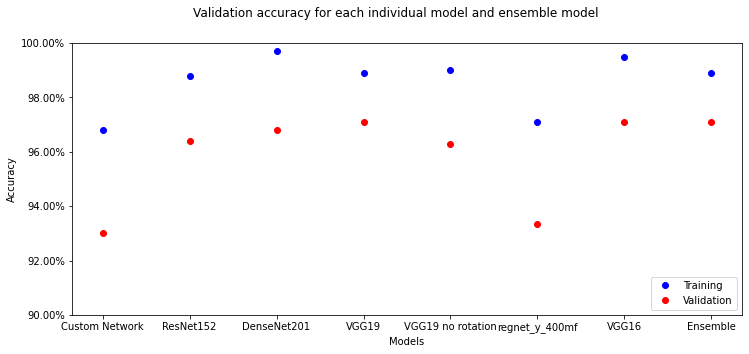

In [ ]:
def model_comparison(models):
    names = models.keys()
    training_acc = [models[model][0] for model in names]
    validation_acc = [models[model][1] for model in names]
    fig, ax = plt.subplots(figsize=(12,5))#figsize=(10,5))
    # set labels
    ax.set_xlabel('Models')
    ax.set_ylim(0.9, 1)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=2))
    ax.set_ylabel("Accuracy")

    # plot
    plt.suptitle("Validation accuracy for each individual model and ensemble model")
    ax.errorbar(names, training_acc, yerr=None, capsize=5, fmt='bo', linestyle='', label='Training')
    ax.errorbar(names, validation_acc, yerr=None, capsize=5, fmt='ro', linestyle='', label='Validation')
    plt.legend(loc='lower right')
    plt.plot()
model_comparison(model_accs)

## Utilizing Unlabeled Data
We will predict the labels for the unlabeled data with voting, then train each model on these assigned labels

In [ ]:
# train the network
def train_model_on_specifit_dataset(net,criterion,optimizer,num_epochs,loader):
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        print("Training epoch %d" % (epoch+1))
        
        running_loss = 0.0
        for i, data in enumerate(loader, 0):
            # get the inputs; data is a list of [inputs, labels]
    
            inputs, labels = data[0].to(device), data[1].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs.float())
        
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # print statistics
            running_loss += loss.item()
            if i % 50 == 49:    # print every 20 mini-batches
                print('\t[Minibatches %d] loss: %.4f' %
                    (i + 1, running_loss / 50))
                running_loss = 0.0      

In [ ]:
# Importing and Reading files
with open("images_ul.pkl", "rb") as f:
    unlabeled_data = pickle.load(f)

In [ ]:
# 5 SPLITS

for i in range(1):
    unlabeled_split = unlabeled_data[(i * 6000):(i + 1) * 6000]
    
    # print(unlabeled_split)
    
    # PREDICT AND LABEL DATA
    cur_dataset = MyCustomDataset(unlabeled_split,transforms=transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(np.mean(unlabeled_split), np.std(unlabeled_split)),
            ]
        ))
    
    cur_loader = torch.utils.data.DataLoader(dataset=cur_dataset, batch_size=128,shuffle=False)
    predictions = predict_vote(models_list,cur_loader,True)

    prediction = [int(p) for p in np.concatenate(predictions)]
    
    train_dataset = MyCustomDataset(
        unlabeled_split,
        prediction,
        transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(np.mean(unlabeled_split), np.std(unlabeled_split)),
                torchvision.transforms.RandomAffine(
                    5, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=0.1
                ),
            ]
        ),
    )
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128,shuffle=False)

    print("Training vgg19_NO_ROTATIONS on subset number ",(i+1))
    train_model_on_specifit_dataset(vgg19_NO_ROTATIONS.to(device),nn.CrossEntropyLoss(),optim.SGD(vgg19_NO_ROTATIONS.parameters(), lr=0.0001, momentum=0.9),10, train_loader)

    print("Training vgg16 on subset number ",(i+1))
    train_model_on_specifit_dataset(vgg16.to(device),nn.CrossEntropyLoss(),optim.SGD(vgg16.parameters(), lr=0.0001, momentum=0.9),10, train_loader)

    print("Training vgg19 on subset number ",(i+1))
    train_model_on_specifit_dataset(vgg19.to(device),nn.CrossEntropyLoss(),optim.SGD(vgg19.parameters(), lr=0.0001, momentum=0.9),10, train_loader)

    print("Training densenet201 on subset number ", (i+1))
    train_model_on_specifit_dataset(densenet201.to(device), nn.CrossEntropyLoss(), optim.Adam(densenet201.parameters(), lr=0.00001, weight_decay=1e-5), 10, train_loader)

    print("Training regnet_y_400mf on subset number ",(i+1))
    train_model_on_specifit_dataset(regnet_y_400mf.to(device),nn.CrossEntropyLoss(),optim.Adam(regnet_y_400mf.parameters(), lr=0.0001, weight_decay=1e-5),10, train_loader)
    
    print("Training resnet18 on subset number ",(i+1))
    train_model_on_specifit_dataset(resnet18.to(device),nn.CrossEntropyLoss(),optim.Adam(resnet18.parameters(), lr=0.0001, weight_decay=1e-5),10, train_loader)
    
    print("Training resnet152 on subset number ",(i+1))
    train_model_on_specifit_dataset(resnet152.to(device),nn.CrossEntropyLoss(),optim.Adam(resnet152.parameters(), lr=0.0001, weight_decay=1e-5),10, train_loader)
    
    print("Training custom_net on subset number ",(i+1))
    train_model_on_specifit_dataset(custom_net, nn.CrossEntropyLoss(),optim.Adam(custom_net.parameters(),lr=0.0005,weight_decay=1e-5),10, train_loader)
    
    print("Training model on subset number ",(i+1))
    train_model_on_specifit_dataset(model, nn.CrossEntropyLoss(),optim.Adam(model.parameters(),lr=0.0005,weight_decay=1e-5),10, train_loader)

    print("Training mnasnet0_5 on subset number ",(i+1))
    train_model_on_specifit_dataset(mnasnet0_5.to(device),nn.CrossEntropyLoss(),optim.Adam(mnasnet0_5.parameters(), lr=0.001, weight_decay=1e-5),10, train_loader)

## Predicting On Test Set For Submission

In [ ]:
predictions = predict_vote(models_list, test_loader, True)

In [ ]:
table = [decoder(predict) for predict in np.concatenate(predictions)]

dataframe = pd.DataFrame(np.vstack(table))
dataframe = dataframe.astype(int)
dataframe = dataframe.astype(str)
dataframe = pd.DataFrame(pd.Series(dataframe.apply("".join, axis=1)))
dataframe.columns = ["Category"]
dataframe.index.name = "# Id"
dataframe.to_csv("test.csv", index=True)

#**Miscellaneous**

###Compare our model's performance for different data augmentation techniques

In [ ]:
def plot_training_and_validation_on_different_data(title, model, results, data_names, color_names, add_line=None):
    fig, ax0 = plt.subplots()

    ax0.set_xlabel("Number of iterations")
    ax0.set_ylabel("Accuracy")
    ax0.tick_params(axis="y", labelcolor="b")
    ax0.legend(["Training accuracy", "Validation accuracy"])

    ax0.set_title(title)


    for result, data_name, color_name in zip(results, data_names, color_names):
        # just plot the training accuracy for the other models 
        training_acc = result[:, 0]
        ax0.plot(range(len(result)), training_acc, color=color_name)

    fig.tight_layout()
    plt.show()


###Plot training vs validation accuracy for our custom model, and training accuracies of all other models

In [ ]:
def plot_training_versus_validation(title, models, results, add_line=None):
    fig, ax0 = plt.subplots()

    ax0.set_xlabel("Number of iterations")
    ax0.set_ylabel("Accuracy")
    ax0.tick_params(axis="y", labelcolor="b")
    ax0.legend(["Training accuracy", "Validation accuracy"])

    ax0.set_title(title)


    # plot our custom model a different color than all other models
    training_acc = results[0][:, 0]
    val_acc = results[0][:, 1]

    ax0.plot(range(len(results)), training_acc, color="navyblue")
    ax0.plot(range(len(results)), val_acc, color="salmon")


    for model, result in zip(models[1:], results[1:]):
        # just plot the training accuracy for the other models 
        training_acc = result[:, 0]
        ax0.plot(range(len(result)), training_acc, color="khaki")

    fig.tight_layout()
    plt.show()

#### Custom transformation class

In [ ]:
class CustomTransformations(object):
    def __init__(self, draw_box=False, blur=False, denoise=False, angle=0):
      self.draw_box = draw_box
      self.blur = blur
      self.denoise = denoise
      self.angle = angle

    # draw bounding boxes around the large features
    def __call__(self, img):
        img = img.astype(np.float64)
        img = img[:,:]
        img = self.rotate_image(img)
        if self.blur:
            img = self.blurImage(img)
        if self.denoise:
            img = self.removeNoise(img)
        if self.draw_box:
            img = self.drawBox(img)
        return img.astype(np.float64)
        
    def __repr__(self):
        return self.__class__.__name__+'()'

    def drawBox(self,img):
        contours, hierarchy  = cv2.findContours(img, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
        for c in contours:
            x,y,w,h = cv2.boundingRect(c)
            if (w >= 10 and w <= 50) and (h >= 10 and h <= 50):
                img = cv2.rectangle(img,(x,y),(x+w,y+h),(150),1)
        return img

    def removeNoise(self,img, threshold = 7):
        img[img < threshold] = 0
        return img

    def blurImage(self,img, sigma=2):
        img = cv2.resize(img, dsize=(100, 100), interpolation=cv2.INTER_CUBIC)
        img = cv2.GaussianBlur(img, (3,3), 2)
        img = cv2.resize(img, dsize=(56, 56), interpolation=cv2.INTER_CUBIC)
        return img

    def rotate_image(self,mat):

        # Source: https://stackoverflow.com/questions/43892506/opencv-python-rotate-image-without-cropping-sides
        height, width = mat.shape[:2] # image shape has 3 dimensions
        image_center = (width/2, height/2) # getRotationMatrix2D needs coordinates in reverse order (width, height) compared to shape
        rotation_mat = cv2.getRotationMatrix2D(image_center, self.angle, 1.)

        # rotation calculates the cos and sin, taking absolutes of those.
        abs_cos = abs(rotation_mat[0,0]) 
        abs_sin = abs(rotation_mat[0,1])

        # find the new width and height bounds
        bound_w = int(height * abs_sin + width * abs_cos)
        bound_h = int(height * abs_cos + width * abs_sin)

        # # subtract old image center (bringing image back to origo) and adding the new image center coordinates
        rotation_mat[0, 2] += bound_w/2 - image_center[0]
        rotation_mat[1, 2] += bound_h/2 - image_center[1]

        # rotate image with the new bounds and translated rotation matrix
        rotated_mat = cv2.warpAffine(mat, rotation_mat, (bound_w, bound_h))
        return cv2.resize(rotated_mat, dsize=(56, 56), interpolation=cv2.INTER_CUBIC)

#### Adding the augmented data to the original data

In [ ]:
# data_augmented1 = np.copy(data)
# data_augmented2 = np.copy(data)
# data_augmented3 = np.copy(data)

# ct1 = CustomTransformations(draw_box=False, blur=False, denoise=False, angle=20)
# ct2 = CustomTransformations(draw_box=False, blur=False, denoise=False, angle=-20)
# ct3 = CustomTransformations(draw_box=False, blur=False, denoise=False, angle=-20)


# for i, im in enumerate(data_augmented1):
#     data_augmented1[i] = ct1.__call__(im)
#     data_augmented2[i] = ct2.__call__(im)
#     data_augmented3[i] = ct3.__call__(im)

# # merge with original data and shuffle
# data = np.vstack((data,data_augmented1, data_augmented2, data_augmented3))
# labels = np.vstack((labels, labels.copy(), labels.copy(), labels.copy()))
# print(data.shape)
# print(labels.shape)

# np.random.seed(1)
# np.random.shuffle(data)
# np.random.seed(1)
# np.random.shuffle(labels)